## Load all required packages

In [1]:
import os 
import glob
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

from shutil import copy
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import load_img
# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence, to_categorical, image_dataset_from_directory
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

current_dir = os.getcwd()

keras.backend.set_image_data_format('channels_last')

2025-03-11 14:36:46.727550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Commonly used function in the notebooks

In [2]:
# Function for converting .tif images to .png and rescaling SAR pixel values. 
# Since our objective is to segment regions with seeps, all the class values mask images were converted to #0: ->(No seep) and #1: -> seep regions 
def tifToPng_scale(path, image_file, img_type=None):
    name = image_file.split('/')[-1][:-4]
    if img_type == 'img':
        scl_img = cv2.imread(image_file) # scale pixel values by a factor of 0.0001
    
    elif img_type == 'msk':
        harm_img = cv2.imread(image_file, -1)
        scl_img = np.where((harm_img>0),1,0) # Set No-seep regions to #0 and seep region to #1
    
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(f'{path}/{name}.png', scl_img)

def tifToPng(path, image_file, img_type=None):
    name = image_file.split('/')[-1][:-4]
    if img_type == 'img':
        scl_img = cv2.imread(image_file)
    
    elif img_type == 'msk':
        scl_img = cv2.imread(image_file)
    
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(f'{path}/{name}.png', scl_img)
    
    
# Funtion to check if all SAR image have their corresponding mask files in same folder    
def check_file(img_ls, msk_ls, outputlist=False):
    images, masks= [],[]
    for i in img_ls:
        iname = i.split('/')[-1].split('_')[-1]
        inum = i.split('/')[-1].split('_')[0]
        msk = [m for m in msk_ls if (iname == m.split('/')[-1].split('_')[-1]) & (inum == m.split('/')[-1].split('_')[0])][0]
        images.append(i)
        masks.append(msk)
        # print(f'image:{i} | mask:{msk}')
        
    if outputlist == True:
        return images, masks
    else:
        print([f'image:{d[0]} --> mask:{d[1]}' for d in zip(images[:5], masks[:5])], '\n')
        

def match_file(img_ls, msk_ls):
    images = []
    masks = []
    for i in img_ls:
        images.append(i)
        name = i.split('_')[-1][:-4]
        masks.append([m for m in msk_ls if name in m][0])
    return images, masks
        
def img_to_array(img_ls, msk_ls):
    img_stack = []
    mask_stack = []
    for i in img_ls:
        name = i.split('_')[-1][:-4]
        msk = [m for m in msk_ls if name in m][0]
        img_stack.append(cv2.imread(i, -1))
        mask_stack.append(cv2.imread(msk, -1))
    return np.array(img_stack), np.array(mask_stack)

# As simple funtion for computing Intersection over Union (IoU) Precision and Racall
def get_metrics(mask_img, pred_img, num_classes):
    iou_met = MeanIoU(num_classes=num_classes)
    _ = iou_met.update_state(mask_img, pred_img)
    iou1 = float(iou_met.result().numpy())

    pres_met = Precision()
    _ = pres_met.update_state(mask_img, pred_img)
    pres = float(pres_met.result().numpy())

    rec_met = Recall()
    _ = rec_met.update_state(mask_img, pred_img)
    rec = float(rec_met.result().numpy())
    mets = {'Mean-IoU':iou1, 'Precision':pres, 'Recall':rec}
    return mets

#Plot Confusing Matrixs
def MyConfMatix(mask_img, pred_img):
    cm = confusion_matrix(mask_img, pred_img, normalize='true')
    cm_df = pd.DataFrame(cm, columns=['No-Tree','Tree'])
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df.round(5), annot=True, cmap='Blues')
    plt.ylabel('Masked Treed')
    plt.xlabel('Predicted Trees')

# Funtion for making Directory
def make_dirs(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

In [6]:
# imgs = sorted(glob.glob('true_imges/image*tif')) # List and sort SAR images
# mask = sorted(glob.glob('true_imges/image*tif')) # List and sort masks

In [3]:
seed = 600
test_samples = 100

def uselast(item):
    return item.split('_')[-1][:-4]
    
input_imgs, input_mask = check_file(glob.glob('true_images/*image*png'),glob.glob('true_images/*mask*png'), outputlist=True)
# input_imgs = sorted(glob.glob('trueMask_images/*image*png'), key=uselast)
# random.Random(seed).shuffle(input_imgs) # List and shuffle scales SAR images

# input_mask = sorted(glob.glob('trueMask_images/*mask*png'), key=uselast)
# random.Random(seed).shuffle(input_mask) # List and shuffle scales mask files

# Make a folder and move training set of images and masks 
[copy(t, make_dirs('merged_train_img/imgs')) for t in input_imgs[:-test_samples]];
[copy(m, make_dirs('merged_train_img/msks')) for m in input_mask[:-test_samples]];

# Make a folder and move validating set of images and masks 
[copy(v, make_dirs('merged_validation_imgs/imgs')) for v in input_imgs[-test_samples:]];
[copy(s, make_dirs('merged_validation_imgs/msks')) for s in input_mask[-test_samples:]];

## Read in the list of training and validation set paths  

In [4]:
# Training list SAR and mask files
train_imgs = sorted(glob.glob('merged_train_img/imgs/*png'))
train_msk = sorted(glob.glob('merged_train_img/msks/*png'))

# # Validation list SAR and mask files
valid_imgs = sorted(glob.glob('merged_validation_imgs/imgs/*png'))
valid_msk = sorted(glob.glob('merged_validation_imgs/msks/*png'))

In [5]:
len(train_imgs)

1050

In [6]:
# Cross check list of taining SAR images corresponds to mask
check_file(train_imgs, train_msk)

['image:merged_train_img/imgs/NS7890_image_1010.png --> mask:merged_train_img/msks/NS7890_mask_1010.png', 'image:merged_train_img/imgs/NS7890_image_109.png --> mask:merged_train_img/msks/NS7890_mask_109.png', 'image:merged_train_img/imgs/NS7890_image_1113.png --> mask:merged_train_img/msks/NS7890_mask_1113.png', 'image:merged_train_img/imgs/NS7890_image_1114.png --> mask:merged_train_img/msks/NS7890_mask_1114.png', 'image:merged_train_img/imgs/NS7890_image_119.png --> mask:merged_train_img/msks/NS7890_mask_119.png'] 



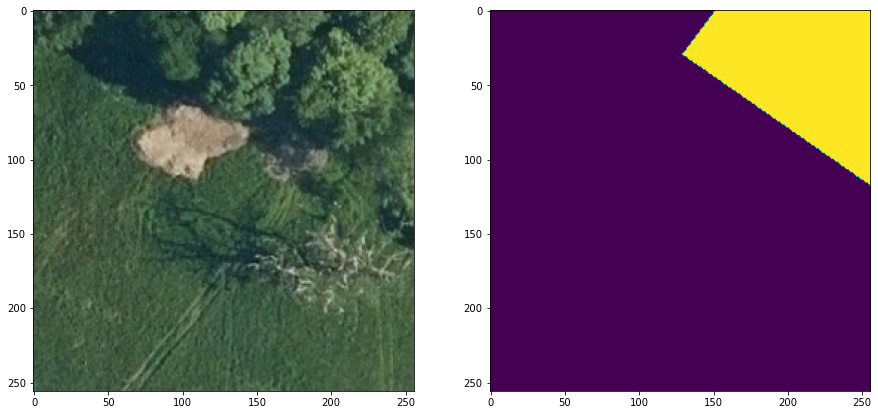

In [11]:
img_idx = 550 # File path List index
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(15, 9))
img0 = cv2.imread(input_imgs[img_idx], -1)
img1 = cv2.imread(input_mask[img_idx], -1)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [77]:
img1.shape

(256, 256)

In [15]:
class image_batch(Sequence):
    def __init__(self, image_path_list, mask_path_list, batch_size, image_dims):
        self.image_path_list = image_path_list
        self.mask_path_list = mask_path_list
        self.batch_size = batch_size
        self.image_dims = image_dims 
        
    # Number of batch in the Sequence
    def __len__(self):
        return len(self.image_path_list) // self.batch_size

    # Get sub epochs
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_list = self.image_path_list[i : i + self.batch_size]
        batch_mask_list = self.mask_path_list[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.image_dims + (3,), dtype="float32")
        for j, path in enumerate(batch_image_list):
            img = load_img(path, target_size=self.image_dims)
            # img = cv2.imread(path)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.image_dims + (1,), dtype="uint8")
        for j, path in enumerate(batch_mask_list):
            img = load_img(path, target_size=self.image_dims, color_mode="grayscale")
            # img = tiff.imread(path)
            y[j] = np.expand_dims(img, 2)
        return x, y

## Build and compile a Deep CNN model based on Unet (Encoder and Decoder) architecture

In [14]:
def segment_model(image_dims, classes):
    input_images = keras.layers.Input(shape=image_dims + (3,))

   # Downsampling block (Encoder layers)
    conv = keras.layers.Conv2D(32, 3, strides=2, padding="same")(input_images)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)

    activation_block = conv

    for filters in [64, 128, 256]: #Filters 3 feature depths  
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.SeparableConv2D(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)
        
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.SeparableConv2D(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)
        conv = keras.layers.MaxPooling2D(3, strides=2, padding="same")(conv)

        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(activation_block) # Project residual
        conv = keras.layers.add([conv, residual])  
        activation_block = conv  

    # Upsampling inputs (Decoder layers)

    for filters in [256,128, 64, 32]: # Filters 4 feature depths  
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.Conv2DTranspose(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)

        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.Conv2DTranspose(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)

        conv = keras.layers.UpSampling2D(2)(conv)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(activation_block)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        conv = keras.layers.add([conv, residual])  # Add back residual
        activation_block = conv  # Set aside next residual

    # Pixel classification layer
    outputs = keras.layers.Conv2D(classes, 3, activation="softmax", padding="same", name="flood_seg_net")(conv)

    # Define and compile the model
#     model = keras.Model(input_images, outputs)
    # loss=tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model = keras.Model(inputs=[input_images], outputs=[outputs])
    model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy")
    return model
# seg_model = segment_model(image_dims=(256,256), classes=2)
# # seg_model.summary()

In [19]:
def segment_model2(image_dims, classes):
    input_images = keras.layers.Input(shape=image_dims + (3,))

   # Downsampling block (Encoder layers)
    conv = keras.layers.Conv2D(32, 3, strides=2, activation='relu', kernel_initializer='he_normal', padding="same")(input_images)
    conv = keras.layers.Dropout(0.2)(conv)

    activation_block = conv

    for filters in [64,128,256]: #Filters 3 feature depths  
        conv = keras.layers.Conv2D(filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(conv)
        conv = keras.layers.Dropout(0.2)(conv)
        conv = keras.layers.Conv2D(filters, 3, activation='relu',padding="same", kernel_initializer='he_normal')(conv)
        conv = keras.layers.MaxPooling2D(3, strides=2, padding="same")(conv)

        residual = keras.layers.Conv2D(filters, 1, strides=2, activation='relu', padding="same", kernel_initializer='he_normal')(activation_block) # Project residual
        conv = keras.layers.add([conv, residual])  
        activation_block = conv  

    # Upsampling inputs (Decoder layers)

    for filters in [256,128, 64, 32]: # Filters 4 feature depths  
        conv = keras.layers.Conv2DTranspose(filters, 3, activation='relu', padding="same")(conv)
        conv = keras.layers.Conv2D(filters, 3, activation='relu', padding="same", kernel_initializer='he_normal')(conv)
        conv = keras.layers.Dropout(0.2)(conv)
        
        conv = keras.layers.UpSampling2D(2)(conv)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(activation_block)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        conv = keras.layers.add([conv, residual])  # Add back residual
        activation_block = conv  # Set aside next residual

    # Pixel classification layer
    outputs = keras.layers.Conv2D(classes, 3, activation="softmax", padding="same", name="flood_seg_net")(conv)

    # Define and compile the model
#     model = keras.Model(input_images, outputs)
    loss=tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model(inputs=[input_images], outputs=[outputs])
    model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy")
    return model
# seg_model = segment_model(image_dims=(256,256), classes=2)
# # seg_model.summary()

In [20]:
image_dims = (256,256)
batch_size = 1
epochs = 30

# Instantiate batch sequence training set
train_batch_generator = image_batch(
    image_path_list = train_imgs, 
    mask_path_list = train_msk,
    batch_size = batch_size,
    image_dims = image_dims
)

# Instantiate batch sequence validation set
valid_batch_generator = image_batch(
    image_path_list = valid_imgs, 
    mask_path_list = valid_msk,
    batch_size = batch_size,
    image_dims = image_dims
)

# Saving models parameters
callbacks = [
    keras.callbacks.ModelCheckpoint('tree_unet_4', save_best_only=True)
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, min_delta=0.0003, restore_best_weights=True)
]

# Training the models
flood_model = segment_model(image_dims=image_dims, classes=2) # Call the model 
flood_model.fit(train_batch_generator, validation_data=valid_batch_generator, epochs=epochs, callbacks=callbacks) # Fit model 

2022-04-26 09:01:30.423646: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.0KiB (rounded to 8192)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-26 09:01:30.423693: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-26 09:01:30.423708: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 90, Chunks in use: 90. 22.5KiB allocated for chunks. 22.5KiB in use in bin. 12.7KiB client-requested in use in bin.
2022-04-26 09:01:30.423719: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 23, Chunks in use: 22. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 11.0KiB client-requested in use in bin.
2022-04-26 09:01:30.423728: I 

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,32,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

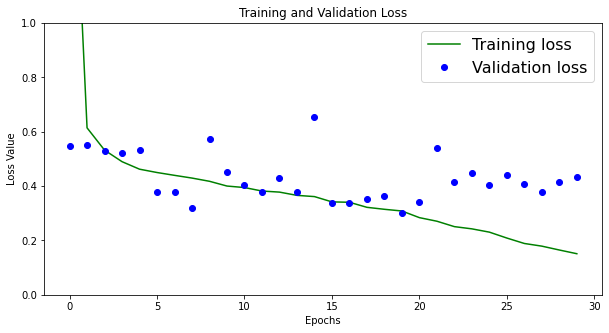

In [22]:
# Get loss values from the trained models
loss = flood_model.history.history['loss']
val_loss = flood_model.history.history['val_loss']

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(loss, 'g', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim(0,1)
plt.legend(fontsize=16)

In [23]:
valid_imgs

['validation_imgs/imgs/NS7890_image_1110.png',
 'validation_imgs/imgs/NS7890_image_1214.png',
 'validation_imgs/imgs/NS7890_image_148.png',
 'validation_imgs/imgs/NS7891_image_06.png',
 'validation_imgs/imgs/NS7891_image_136.png',
 'validation_imgs/imgs/NS7891_image_211.png',
 'validation_imgs/imgs/NS7891_image_413.png',
 'validation_imgs/imgs/NS7891_image_60.png',
 'validation_imgs/imgs/NS7891_image_71.png',
 'validation_imgs/imgs/NS7891_image_711.png',
 'validation_imgs/imgs/NS7891_image_81.png',
 'validation_imgs/imgs/NS7891_image_914.png',
 'validation_imgs/imgs/NS7891_image_96.png',
 'validation_imgs/imgs/NS7892_image_06.png',
 'validation_imgs/imgs/NS7892_image_103.png',
 'validation_imgs/imgs/NS7892_image_104.png',
 'validation_imgs/imgs/NS7892_image_108.png',
 'validation_imgs/imgs/NS7892_image_210.png',
 'validation_imgs/imgs/NS7892_image_28.png',
 'validation_imgs/imgs/NS7892_image_311.png',
 'validation_imgs/imgs/NS7892_image_513.png',
 'validation_imgs/imgs/NS7892_image_714

## Predicting image segmentation 
#### Runing multiple predictions on the SAR valadation images 

In [65]:
pred_directory = 'predicted_files16' # Set folder for the prediction
for idx, path in enumerate(valid_imgs):
    name = path.split('/')[-1]
    val_gen2 = image_batch(
    [valid_imgs[idx]], [valid_msk[idx]], batch_size=1, image_dims=(256,256)
    )
    print(val_gen2)

    preds = flood_model.predict(val_gen2)
    arr = np.argmax(preds[0], axis=-1)
    # dir_ = make_dirs(pred_directory)
    # cv2.imwrite(f'{dir_}/{name}', arr)  

In [59]:
np.unique(arr)

array([0, 1])

In [26]:
pred_list = glob.glob(pred_directory + '/*png')

iou_dict = {'Image':[], 'IOU':[]}
for idx in np.arange(len(valid_imgs)):
    pred_file = pred_list[idx]
    name = pred_file.split('/')[-1]
    mask_file = [m for m in valid_msk if name.split('_')[-1] in m][0]
    # print(pred_file, mask_file)

    pred_seg = cv2.imread(pred_file,-1)
    pred_seg[pred_seg>0]=1
    mask_seg = cv2.imread(mask_file,-1)
    
    iou_met = MeanIoU(num_classes=2)
    _ = iou_met.update_state(mask_seg, pred_seg)
    iou1 = np.round(iou_met.result().numpy(), 2)
    
    
#     iou = get_iouScore(mask_seg, pred_seg)
#     iou2 = get_iouScore2(actual_img, pred_img, num_classes=2)
    iou_dict['Image'].append(pred_file)
    iou_dict['IOU'].append(iou1)
#     print(f'Image:{name}, IOU:{iou.round(2)}, IOUk:{iou1}')
iou_df = pd.DataFrame(iou_dict)
top_5 = iou_df.sort_values(by='IOU', ascending=False).head(8)
top_5

,Image,IOU
39,predicted_files16/NS8091_image_1414.png,1.00
47,predicted_files16/NS7891_image_60.png,1.00
29,predicted_files16/NS7891_image_81.png,1.00
82,predicted_files16/NS7892_image_714.png,1.00
87,predicted_files16/NS7891_image_71.png,1.00
10,predicted_files16/NS7991_image_612.png,0.90
41,predicted_files16/NS7891_image_96.png,0.87
96,predicted_files16/NS7992_image_510.png,0.87


In [90]:
check_file(pred_list, valid_msk)

['image:predicted_files16/NS8097_image_311.png --> mask:validation_imgs/msks/NS8097_mask_311.png', 'image:predicted_files16/NS8196_image_39.png --> mask:validation_imgs/msks/NS8196_mask_39.png', 'image:predicted_files16/NS8097_image_06.png --> mask:validation_imgs/msks/NS8097_mask_06.png', 'image:predicted_files16/NS8097_image_12.png --> mask:validation_imgs/msks/NS8097_mask_12.png', 'image:predicted_files16/NS8196_image_05.png --> mask:validation_imgs/msks/NS8196_mask_05.png'] 



In [38]:
pred_files, mask_files = match_file(pred_list, valid_msk)

for p, m in zip(pred_files,mask_files):
    img1 = cv2.imread(p, -1)
    img1[img1>0]=1
    img2 = cv2.imread(m, -1)

    eval_mets = get_metrics(img2, img1, num_classes=2)
    print(eval_mets)

{'Mean-IoU': 0.7022087574005127, 'Precision': 0.7074407935142517, 'Recall': 0.7144890427589417}
{'Mean-IoU': 0.7284477353096008, 'Precision': 0.7661354541778564, 'Recall': 0.6768743395805359}
{'Mean-IoU': 0.6237393617630005, 'Precision': 0.7479674816131592, 'Recall': 0.3056478500366211}
{'Mean-IoU': 0.7393636703491211, 'Precision': 0.7045769691467285, 'Recall': 0.6479591727256775}
{'Mean-IoU': 0.8098034858703613, 'Precision': 0.9495459198951721, 'Recall': 0.6755204796791077}
{'Mean-IoU': 0.6236671209335327, 'Precision': 0.38898757100105286, 'Recall': 0.505773663520813}
{'Mean-IoU': 0.8054499626159668, 'Precision': 0.7052785754203796, 'Recall': 0.8528369069099426}
{'Mean-IoU': 0.8005783557891846, 'Precision': 0.8037919998168945, 'Recall': 0.8334822654724121}
{'Mean-IoU': 0.8152878880500793, 'Precision': 1.0, 'Recall': 0.6330274939537048}
{'Mean-IoU': 0.7464377880096436, 'Precision': 0.8347193598747253, 'Recall': 0.7247292399406433}
{'Mean-IoU': 0.499176025390625, 'Precision': 0.0, 'Reca

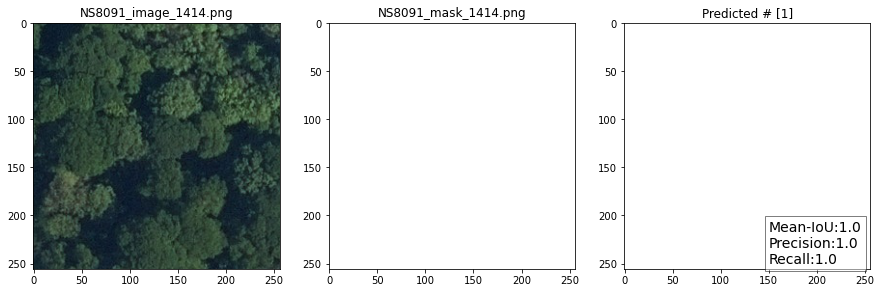

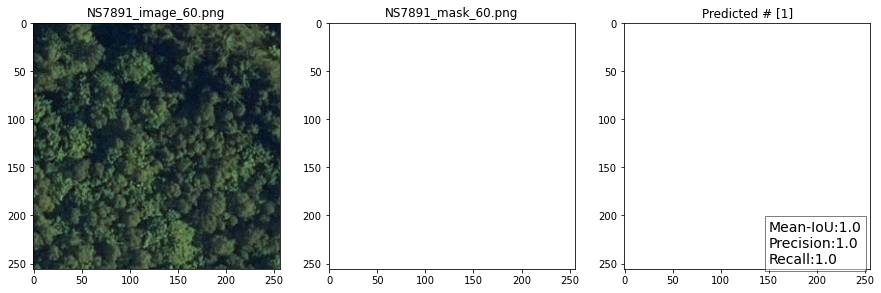

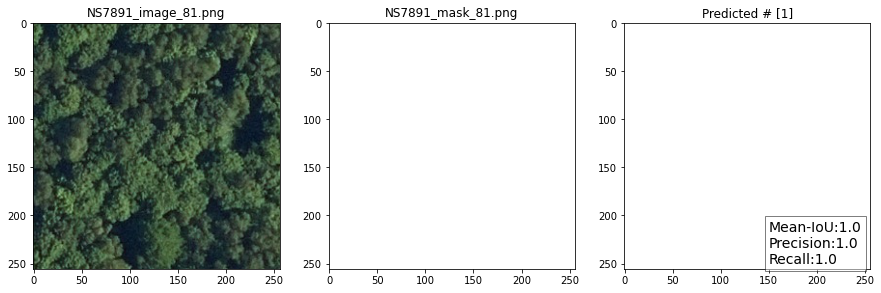

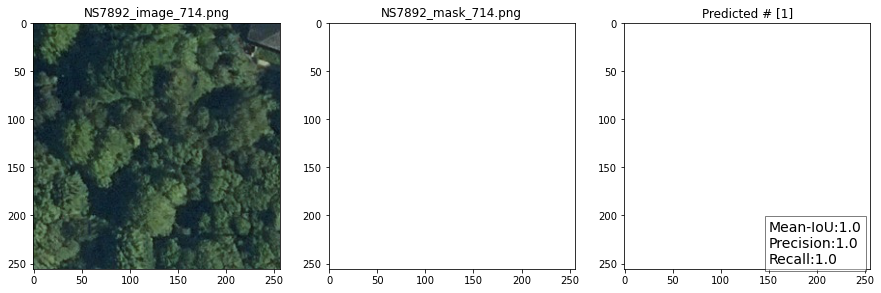

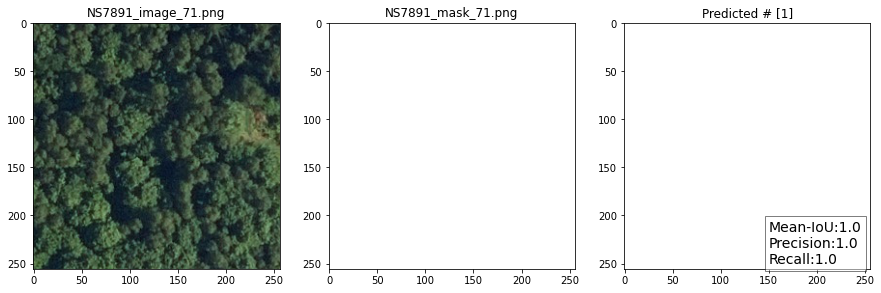

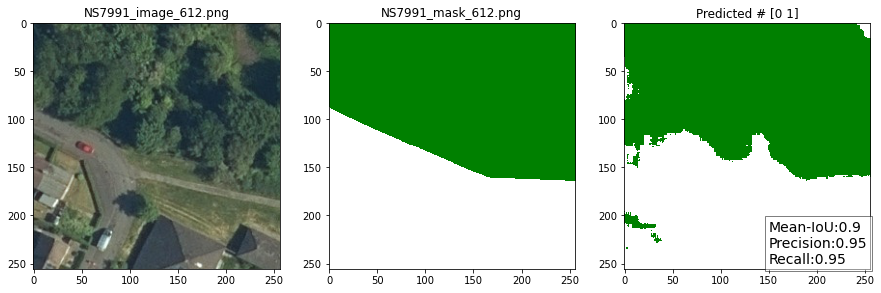

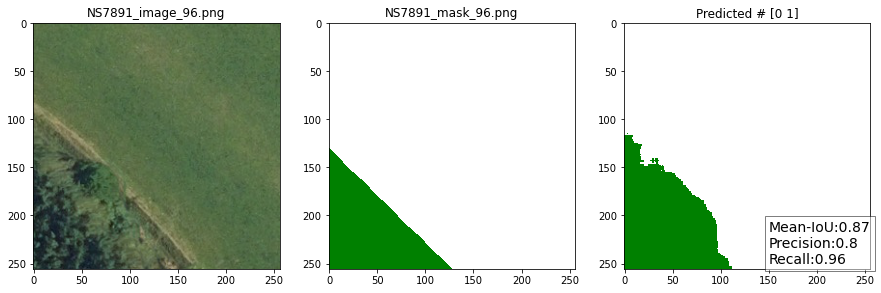

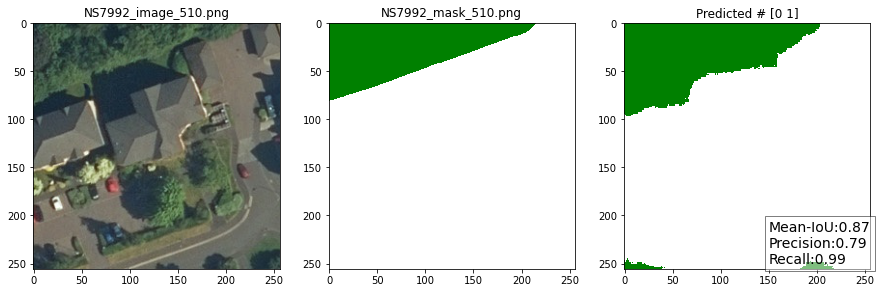

In [35]:


# make a color map of fixed colors
cmap = colors.ListedColormap(['white', 'green'])

for t in top_5.Image.to_list():
    fn = t.split('/')[-1].split('_')[-1]
    img_file = [m for m in valid_imgs if fn == m.split('/')[-1].split('_')[-1]][0]    
    mask_file = [m for m in valid_msk if fn == m.split('/')[-1].split('_')[-1]][0]
    # pred_file = [m for m in pred_list if t in m][0]
    
    img0 = cv2.imread(img_file, -1)
    img1 = cv2.imread(mask_file, -1)
    img2 = cv2.imread(t, -1)
    img2[img2>0]=1
    
    eval_mets = get_metrics(img1, img2, num_classes=2)
    iou, pres, rec = eval_mets['Mean-IoU'], eval_mets['Precision'], eval_mets['Recall']
    file = img_file.split('/')[-1]
    mask = mask_file.split('/')[-1]
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 9))
    for a, ax in enumerate(axs.reshape(-1)):
        arr = [img0, img1, img2][a]
        cat = [f'{file}',f'{mask}', 'Predicted'][a]
#         file = t.split('.')[1]
        ax.set_title(f'{cat}')
        if cat == 'Predicted':
            ax.set_title(f'{cat} # {np.unique(arr)}' )
            txt = ax.text(x=150, y=250, s=f'Mean-IoU:{np.round(iou, 2)}\nPrecision:{np.round(pres, 2)}\nRecall:{np.round(rec, 2)}', fontsize=14)
            txt.set_bbox(dict(facecolor='white', alpha=0.5))   
        ax.imshow(arr, cmap=cmap)

In [48]:
from patchify import patchify, unpatchify
import rasterio
select_imgs = []

for n in ['NS789','NS799', 'NS809']:
    for i in range(5):
        select_imgs.append('SegImage/'+n+f'{i}.jpg')
select_imgs.sort()
test = select_imgs[12:]
test

['SegImage/NS8092.jpg', 'SegImage/NS8093.jpg', 'SegImage/NS8094.jpg']

In [ ]:
flood_model.pr

In [67]:
test_img =rasterio.open(test[0])
input_patch = patchify(test_img.read(), patch_size=(3, 256,256), step=256)
out_patch = patchify(test_img.read(1), patch_size=(256,256), step=256)
pred_tile = np.zeros(out_patch.shape)
for i in np.arange(input_patch.shape[1]):
    for s in np.arange(input_patch.shape[2]):
        single_patch = np.expand_dims(np.transpose(input_patch[0,i,s,:,:,:], (1,2,0)), axis=0)
        print(single_patch.shape)
        preds = flood_model.predict(single_patch)
        arr = np.argmax(preds[0], axis=-1)
        print(arr.shape)
        
        # pred_tile[i,s,:,:]  = arr

(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 

In [56]:

out

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [45]:
timg

## Model Performance Evaluation 
### The Mean Intersection over Union (MeanIoU), Precision and Recall scores were used to assess how well the deep CNN model predicted/separated the seep regions in the validation images. To achieve this, the predicted images were compared the validation mask files.

### The MeanIoU enabled the quatification of the degree of overlap between the predicted seep region and target mask. The precision tells us how accurate the correctly predicted tree pixels agreed with the masked seep regions while the Recall on the other hand quantifes total amount of masked seep pixel were predicted to be true.

##  Calculate the Mean-IoU for each predited image and selecting the top 5

In [199]:
pred_list = glob.glob('predicted_files1/*tif')

iou_dict = {'Image':[], 'IOU':[]}
for idx in np.arange(len(valid_imgs)):
    pred_file = pred_list[idx]
    name = pred_file.split('/')[-1]
    print(name)
    mask_file = [m for m in valid_msk if name == m][0]

    pred_seg = cv2.imread(pred_file,-1)
    mask_seg = cv2.imread(mask_file,-1)
    
    iou_met = MeanIoU(num_classes=2)
    _ = iou_met.update_state(mask_seg, pred_seg)
    iou1 = np.round(iou_met.result().numpy(), 2)
    
    iou_dict['Image'].append(name)
    iou_dict['IOU'].append(iou1)
#     print(f'Image:{name}, IOU:{iou1}')
iou_df = pd.DataFrame(iou_dict)
top_5 = iou_df.sort_values(by='IOU', ascending=False).head()
top_5

image_58.tif


IndexError: list index out of range

## Plot top five SAR Images, Corresponding Masks and Predictions
#### From the first image, IoU shows about 89% overlap of the predicted seeps over the masks 

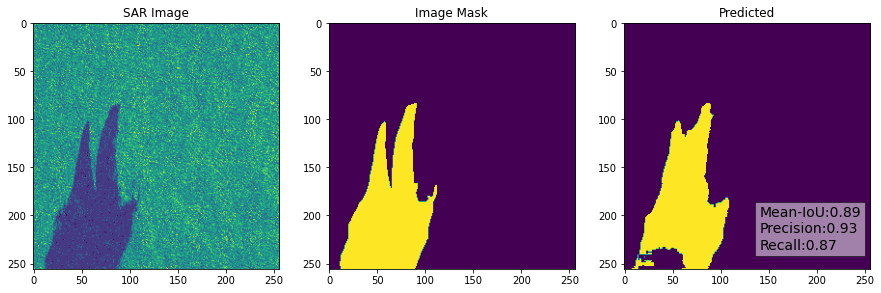

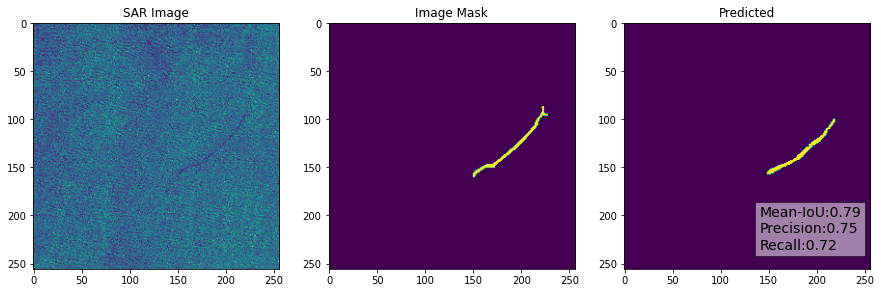

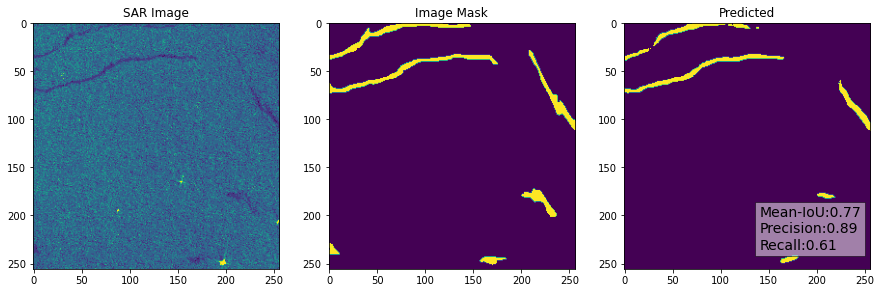

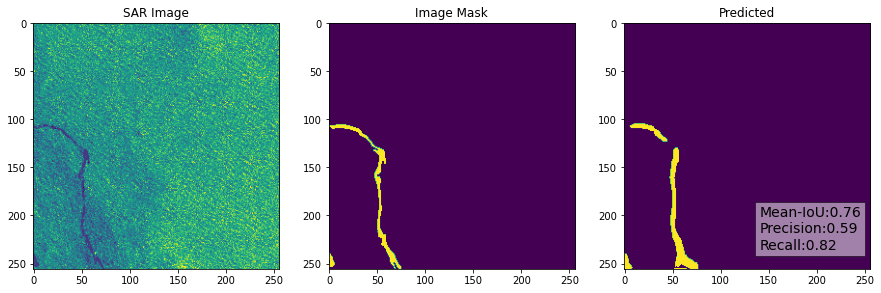

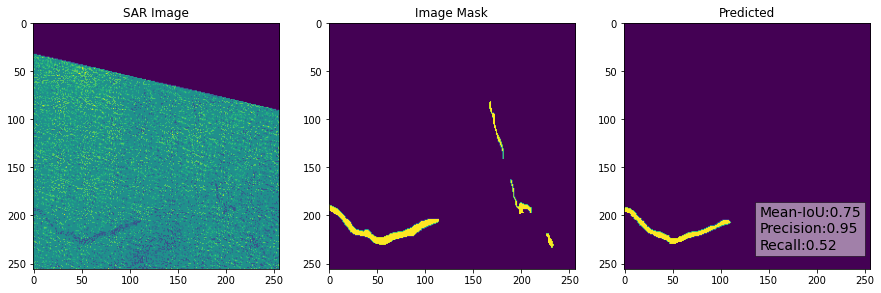

In [37]:
for t in top_5.Image.tolist():
    img_file = [m for m in valid_imgs if t in m][0]    
    mask_file = [m for m in valid_msk if t in m][0]
    pred_file = [m for m in pred_list if t in m][0]
    
    img0 = cv2.imread(img_file,-1)
    img1 = cv2.imread(mask_file,-1)
    img2 = cv2.imread(pred_file,-1)
    
    eval_mets = get_metrics(img1, img2, num_classes=2)
    iou, pres, rec = eval_mets['Mean-IoU'], eval_mets['Precision'], eval_mets['Recall']
    
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 9))
    for a, ax in enumerate(axs.reshape(-1)):
        arr = [img0, img1, img2][a]
        cat = ['SAR Image','Image Mask', 'Predicted'][a]
#         file = t.split('.')[1]
        ax.set_title(f'{cat}')
        if cat == 'Predicted':
            ax.set_title(f'{cat}')
            txt = ax.text(x=140, y=235, s=f'Mean-IoU:{np.round(iou, 2)}\nPrecision:{np.round(pres,2)}\nRecall:{np.round(rec,2)}', fontsize=14)
            txt.set_bbox(dict(facecolor='white', alpha=0.5))   
        ax.imshow(arr)

## Normalised Confusion Matrix Plots for to 5 IoU
### Again in the first plot, we see that of the total masked seep pixs, 87% of it was predited to be true which also agrees with the Recall, in the figure above 

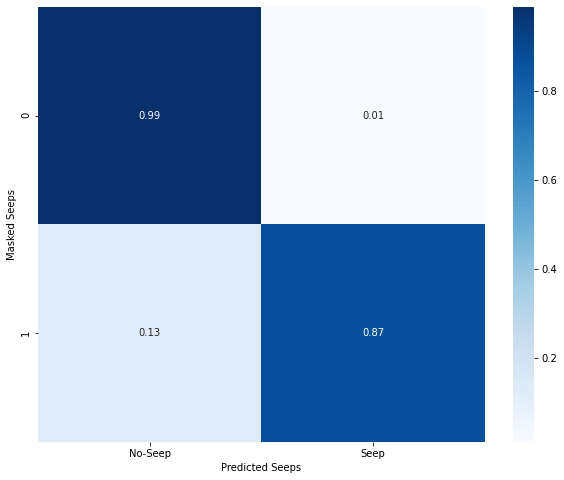

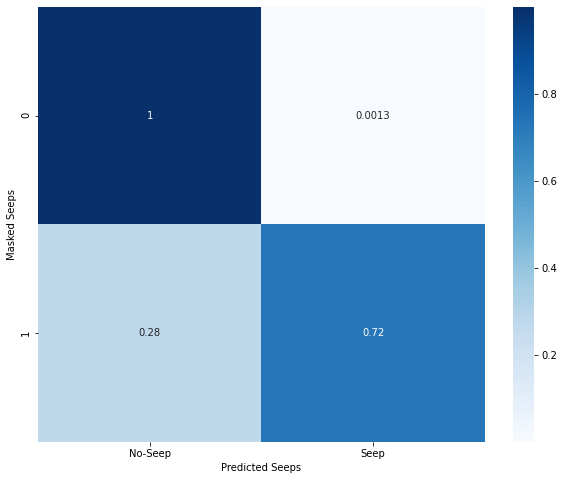

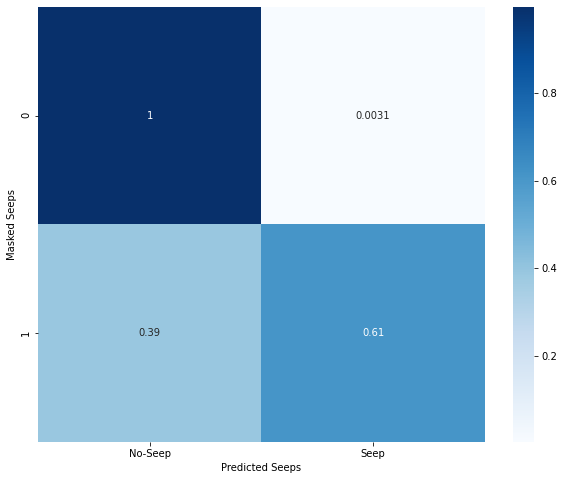

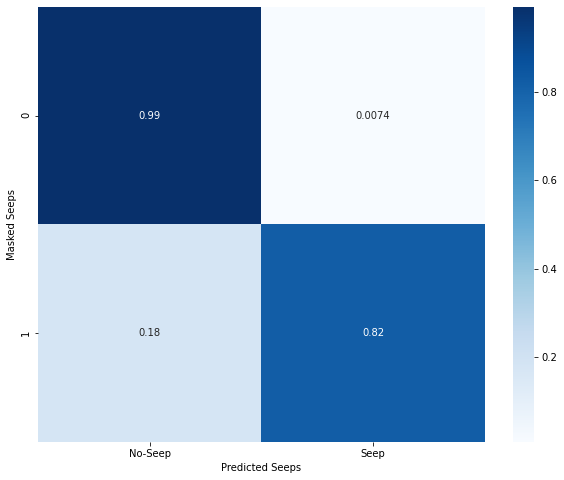

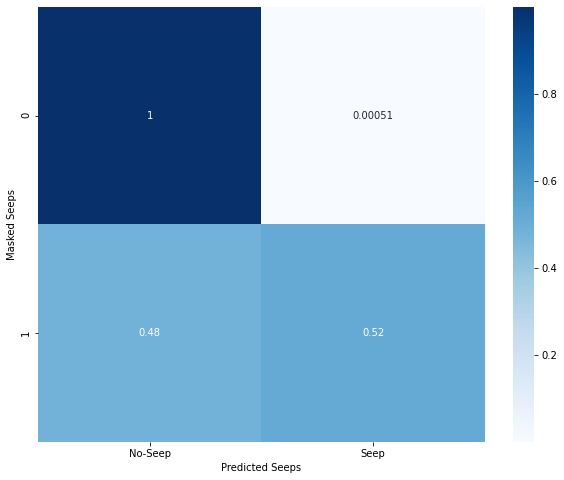

In [38]:
for t in top_5.Image.tolist():
    img_file = [m for m in valid_imgs if t in m][0]    
    mask_file = [m for m in valid_msk if t in m][0]
    pred_file = [m for m in pred_list if t in m][0]
    
    img0 = cv2.imread(img_file,-1)
    img1 = cv2.imread(mask_file,-1)
    img2 = cv2.imread(pred_file,-1)

    MyConfMatix(img1.ravel(), img2.ravel())

## Plot All SAR Images, Masks and Predictions

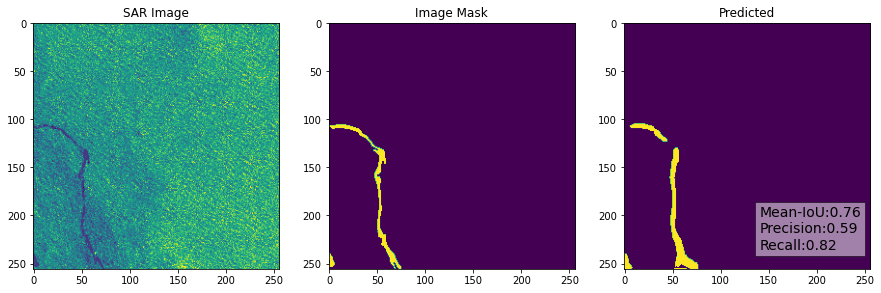

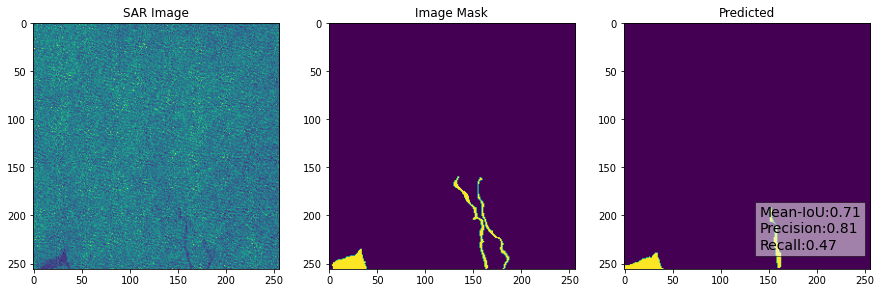

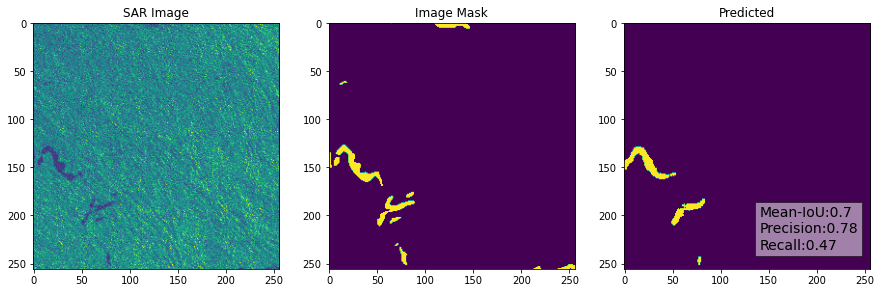

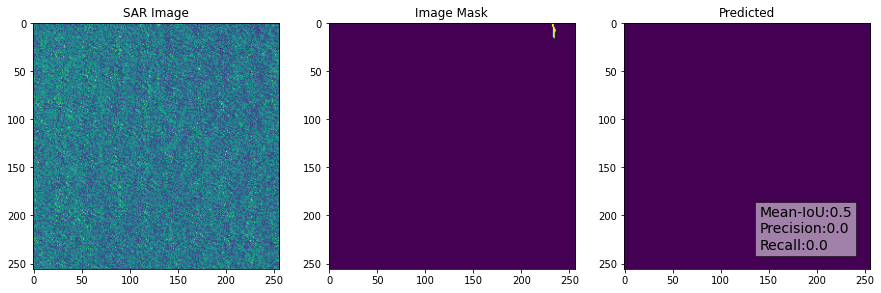

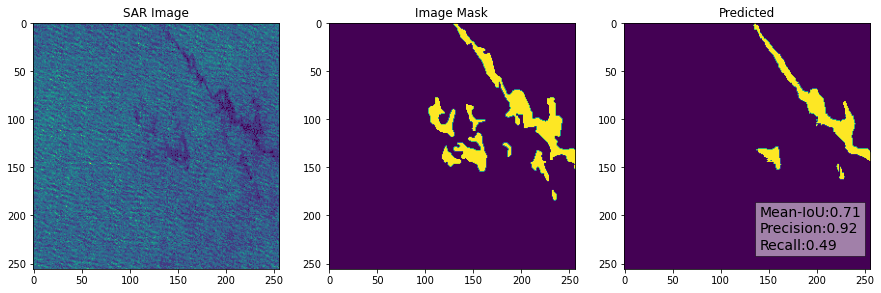

In [39]:
for idx in np.arange(5): # 5
    pred_file = pred_list[idx]
    name = pred_file.split('/')[-1][:-4]
    img_file = [m for m in valid_imgs if name in m][0]    
    mask_file = [m for m in valid_msk if name in m][0]
    
    img0 = cv2.imread(img_file,-1)
    img1 = cv2.imread(mask_file,-1)
    img2 = cv2.imread(pred_file,-1)
    
    eval_mets = get_metrics(img1, img2, num_classes=2)
    iou, pres, rec = eval_mets['Mean-IoU'], eval_mets['Precision'], eval_mets['Recall']
    
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 9))
    for a, ax in enumerate(axs.reshape(-1)):
        arr = [img0, img1, img2][a]
        cat = ['SAR Image','Image Mask', 'Predicted'][a]
#         file = t.split('.')[1]
        ax.set_title(f'{cat}')
        if cat == 'Predicted':
            ax.set_title(f'{cat}')
            txt = ax.text(x=140, y=235, s=f'Mean-IoU:{np.round(iou, 2)}\nPrecision:{np.round(pres,2)}\nRecall:{np.round(rec,2)}', fontsize=14)
            txt.set_bbox(dict(facecolor='white', alpha=0.5))   
        ax.imshow(arr)

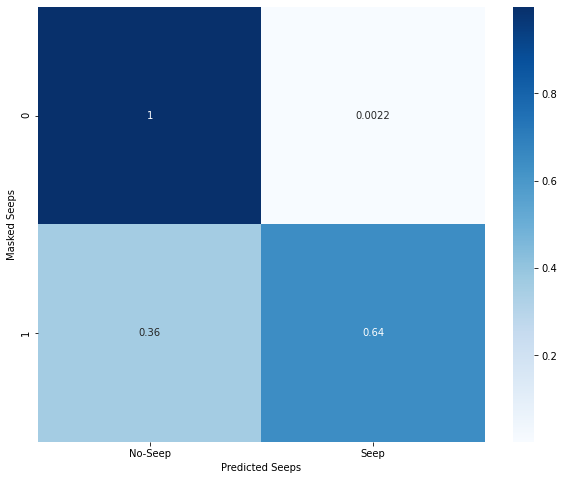

In [28]:
MyConfMatix(img1.ravel(), img2.ravel())